# Generalized OT Geodesics: Parameter Studies

This notebook studies:
1. Impact of the temperature $\beta$ (single Gaussian to Gaussian mixture).
2. Impact of variance $\sigma^2$ (single Gaussian to single Gaussian).

All runs use a 5-stage decaying gamma schedule from $1$ to $10^{-4}$ and `n=50` particles.

In [1]:
import sys
import importlib
from pathlib import Path

# Local path or Colab path support
repo_root = Path.cwd().resolve().parent if Path.cwd().name == 'example' else Path.cwd().resolve()

if 'google.colab' in sys.modules:
    try:
        from subprocess import run
        colab_repo = Path('/content/generalized-ot-geodesics')
        if not (colab_repo / 'ot_geodesics').exists():
            run([
                'git', 'clone',
                'https://github.com/gpeyre/generalized-ot-geodesics.git',
                str(colab_repo),
            ], check=False)
        if (colab_repo / 'ot_geodesics').exists():
            repo_root = colab_repo
        try:
            import ot  # type: ignore
        except Exception:
            run([sys.executable, '-m', 'pip', 'install', '-q', 'POT'], check=False)
            import ot  # type: ignore
    except Exception as e:
        print('Colab repo setup skipped:', e)

if (repo_root / 'ot_geodesics').exists() and str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

if not (repo_root / 'ressources').exists() and (Path('/content/generalized-ot-geodesics') / 'ressources').exists():
    repo_root = Path('/content/generalized-ot-geodesics')

import matplotlib.pyplot as plt
import numpy as np
import torch

import ot_geodesics.solver as solver_mod
importlib.reload(solver_mod)
optimize_with_gamma_schedule = solver_mod.optimize_with_gamma_schedule

import ot_geodesics.helper as helper_mod
importlib.reload(helper_mod)
draw_trajectories = helper_mod.draw_trajectories
compute_global_bbox = helper_mod.compute_global_bbox

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
if device == 'cuda':
    print('CUDA:', torch.cuda.get_device_name(0))

torch.manual_seed(7)
np.random.seed(7)


Device: cpu


In [2]:
def sample_single_gaussian(mean, sigma, n, dtype=torch.float64):
    mean_t = torch.tensor(mean, dtype=dtype).reshape(2, 1)
    return mean_t + sigma * torch.randn(2, n, dtype=dtype)


def sample_mixture_two_gaussians(mean_a, mean_b, sigma, n, weight_a=0.5, dtype=torch.float64):
    n_a = int(round(weight_a * n))
    n_a = min(max(n_a, 1), n - 1)
    n_b = n - n_a
    x_a = sample_single_gaussian(mean_a, sigma, n_a, dtype=dtype)
    x_b = sample_single_gaussian(mean_b, sigma, n_b, dtype=dtype)
    x = torch.cat([x_a, x_b], dim=1)
    perm = torch.randperm(n)
    return x[:, perm]


## 1) Impact of $\beta$ (single Gaussian $X_0$ to two-Gaussian mixture $X_1$)

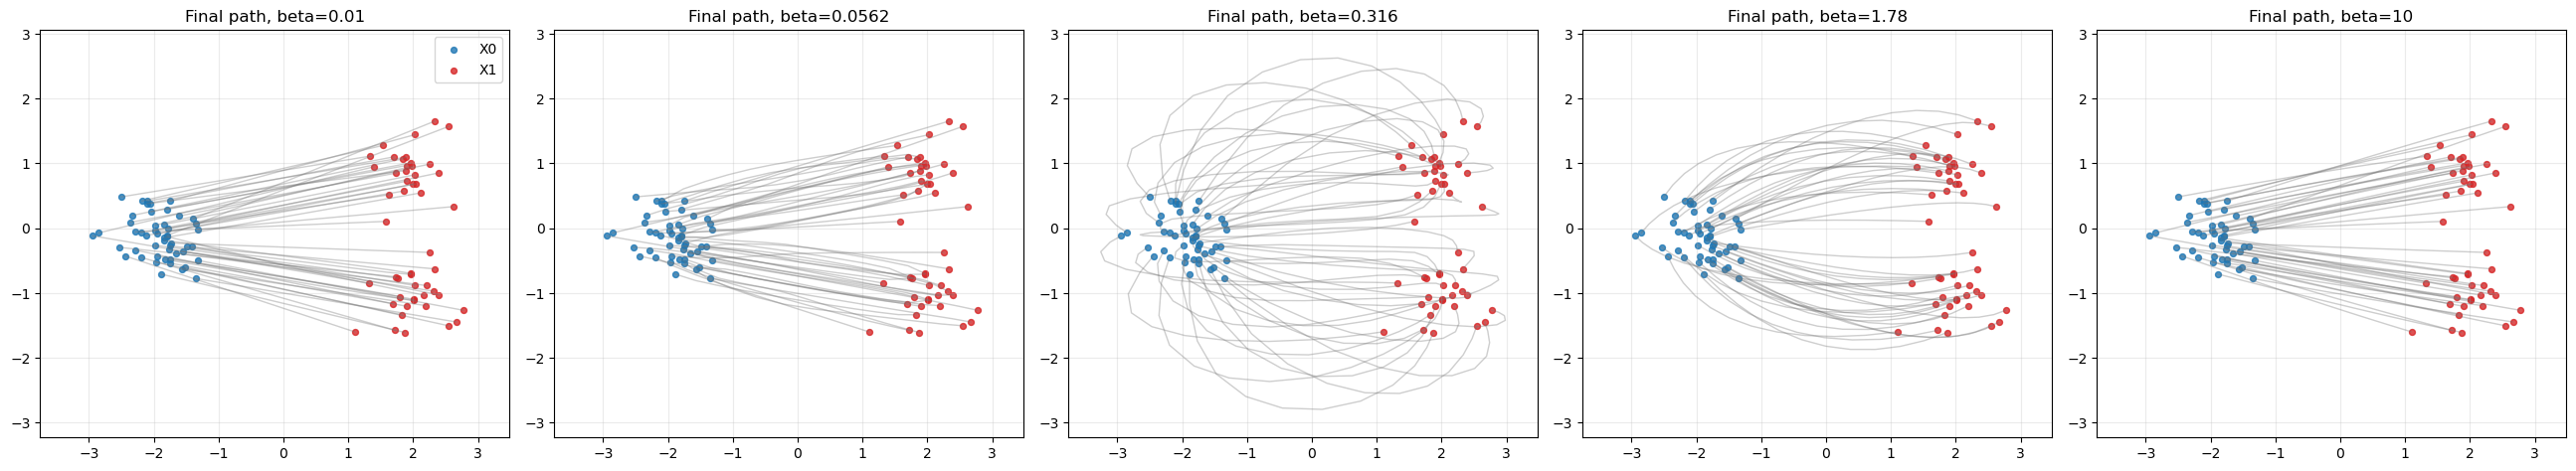

In [3]:
n = 50
t_steps = 12
gammas = np.geomspace(1.0, 1e-4, 5)
betas = np.geomspace(0.01, 10.0, 5)

x0 = sample_single_gaussian(mean=[-2.0, 0.0], sigma=0.35, n=n)
x1 = sample_mixture_two_gaussians(
    mean_a=[2.0, -1.0],
    mean_b=[2.0, 1.0],
    sigma=0.35,
    n=n,
)

x_init = x0.unsqueeze(2).repeat(1, 1, t_steps)

final_paths_by_beta = {}
for beta in betas:
    scheduled_results = optimize_with_gamma_schedule(
        x0=x0,
        x1=x1,
        gammas=gammas,
        t_steps=t_steps,
        max_iter=35,
        tolerance=1e-8,
        snapshot_every=35,
        initial_path=x_init,
        phi_mode='transformer',
        beta=float(beta),
        optimizer_mode='lbfgs',
        lbfgs_lr=1.0,
        lbfgs_max_iter=20,
        device=device,
        dtype=torch.float64,
    )
    final_paths_by_beta[float(beta)] = scheduled_results[-1].path

bbox_beta_list = [compute_global_bbox(final_paths_by_beta[float(beta)], pad_ratio=0.08) for beta in betas]
x_min = min(b[0] for b in bbox_beta_list)
x_max = max(b[1] for b in bbox_beta_list)
y_min = min(b[2] for b in bbox_beta_list)
y_max = max(b[3] for b in bbox_beta_list)

fig, axes = plt.subplots(1, len(betas), figsize=(5.2 * len(betas), 4.6), squeeze=False)
for k, beta in enumerate(betas):
    draw_trajectories(
        final_paths_by_beta[float(beta)],
        x0,
        x1,
        title=f'Final path, beta={beta:.3g}',
        ax=axes[0, k],
        show=False,
        show_legend=(k == 0),
        n_max=n,
        show_intermediate_dots=False,
        endpoint_size=18,
        line_width=1.0,
    )
    axes[0, k].set_xlim(x_min, x_max)
    axes[0, k].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


## 2) Impact of variance $\sigma^2$ (single Gaussian $X_0$ to single Gaussian $X_1$, fixed $\beta=1$)

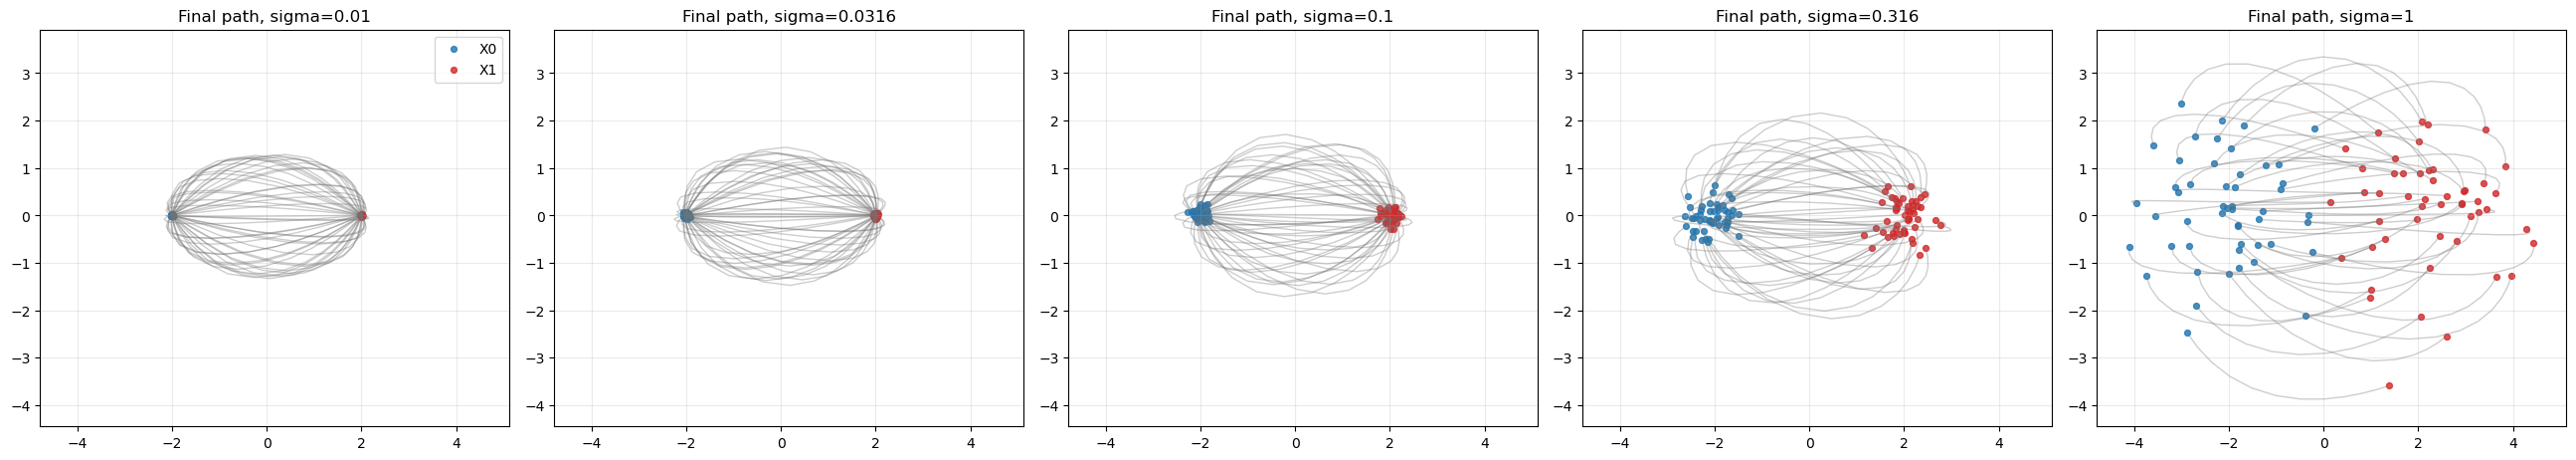

In [4]:
n = 50
t_steps = 12
gammas = np.geomspace(1.0, 1e-4, 5)
beta = 1.0
sigmas = np.geomspace(0.01, 1.0, 5)

final_paths_by_sigma = {}
clouds_by_sigma = {}

for sigma in sigmas:
    x0_s = sample_single_gaussian(mean=[-2.0, 0.0], sigma=float(sigma), n=n)
    x1_s = sample_single_gaussian(mean=[2.0, 0.0], sigma=float(sigma), n=n)
    x_init_s = x0_s.unsqueeze(2).repeat(1, 1, t_steps)

    scheduled_results = optimize_with_gamma_schedule(
        x0=x0_s,
        x1=x1_s,
        gammas=gammas,
        t_steps=t_steps,
        max_iter=35,
        tolerance=1e-8,
        snapshot_every=35,
        initial_path=x_init_s,
        phi_mode='transformer',
        beta=beta,
        optimizer_mode='lbfgs',
        lbfgs_lr=1.0,
        lbfgs_max_iter=20,
        device=device,
        dtype=torch.float64,
    )
    final_paths_by_sigma[float(sigma)] = scheduled_results[-1].path
    clouds_by_sigma[float(sigma)] = (x0_s, x1_s)

bbox_sigma_list = [compute_global_bbox(final_paths_by_sigma[float(sigma)], pad_ratio=0.08) for sigma in sigmas]
x_min = min(b[0] for b in bbox_sigma_list)
x_max = max(b[1] for b in bbox_sigma_list)
y_min = min(b[2] for b in bbox_sigma_list)
y_max = max(b[3] for b in bbox_sigma_list)

fig, axes = plt.subplots(1, len(sigmas), figsize=(5.2 * len(sigmas), 4.6), squeeze=False)
for k, sigma in enumerate(sigmas):
    x0_s, x1_s = clouds_by_sigma[float(sigma)]
    draw_trajectories(
        final_paths_by_sigma[float(sigma)],
        x0_s,
        x1_s,
        title=f'Final path, sigma={sigma:.3g}',
        ax=axes[0, k],
        show=False,
        show_legend=(k == 0),
        n_max=n,
        show_intermediate_dots=False,
        endpoint_size=18,
        line_width=1.0,
    )
    axes[0, k].set_xlim(x_min, x_max)
    axes[0, k].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


The plots above show only the final interpolating paths obtained after the full gamma schedule for each parameter setting.